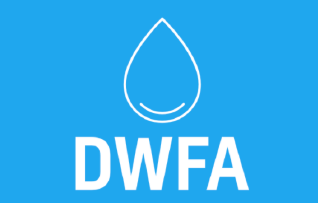

In [1]:
# import librairies needed for project
import missingno as msno
import numpy as np
import pandas as pd
import mysql.connector as connector
from mysql.connector import Error

# import user-created functions
from functions import *

# maximise dataframe display
pd.set_option('display.max_colwidth', None)

# remove scientific notation format for large numbers in dataframes
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# use company logo colour in graphs
col = findColor('dwfa_blue.png')
print("Logo color hex:", col)

Logo color hex: #1fa7ee


In [2]:
# initiate connection to database
try:
    connection = connector.connect(
    host="127.0.0.1",
    port=3306,
    user="root",
    password="1234",
    auth_plugin='mysql_native_password',
    database="dwfa",
    autocommit=True)
    if connection.is_connected():
        print("Connection to DWFA database successful !")
        
except Error as e:
    print("Error while connecting to DWFA database", e)

Connection to DWFA database successful !


In [3]:
cursor = connection.cursor()

### 1 - table countries

In [4]:
# import file - source : 
countries = pd.read_csv('countries.csv', encoding='latin_1')
countries.describe()

,REGION (DISPLAY),COUNTRY (DISPLAY)
count,194,194
unique,6,194
top,Europe,Albania
freq,53,1


<AxesSubplot:>

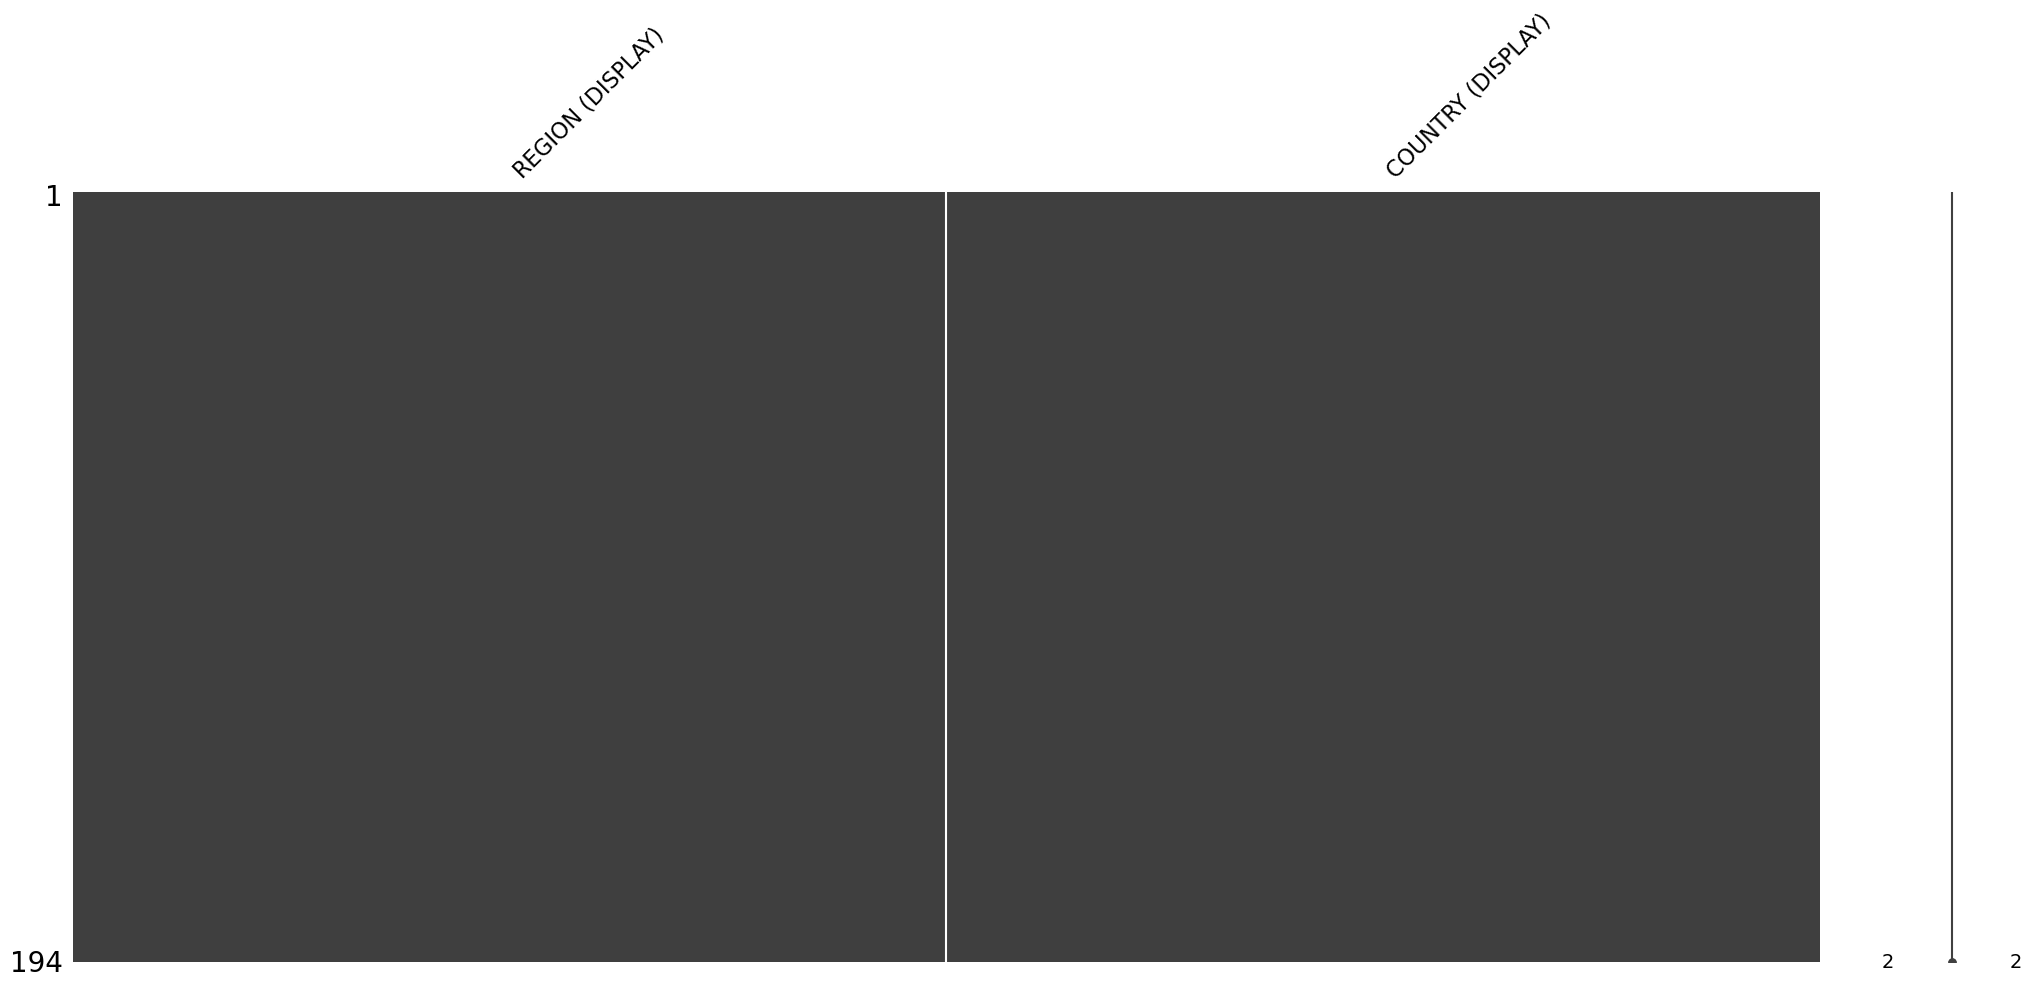

In [5]:
msno.matrix(countries)

In [6]:
# count number of null values in countries dataframe
nulls_c = countries.isna().sum().sum()
if nulls_c == 0:
    print("There are no null values in the table.")
else:
    print ("There are ", nulls_c, "null values in the table.")

There are no null values in the table.


In [7]:
# rename columns
countries.rename(columns={'REGION (DISPLAY)': 'region', 'COUNTRY (DISPLAY)':'country_name'}, inplace=True)

In [8]:
# type casting
countries['country_name'] = countries['country_name'].astype('string')
countries['region'] = countries['region'].astype('string')

In [9]:
print ("Il y a",countries['country_name'].nunique(), "pays dans la liste.")
if (countries.loc[countries.duplicated() == True].shape[0]) != 0:
    print("Doublons dans la table.")
else:
    print ("Aucun doublon dans la table.")

Il y a 194 pays dans la liste.
Aucun doublon dans la table.


In [10]:
# check if country name is a primary key
isCandKey(countries, 'country_name')

country_name est une clé candidate.


True

In [12]:
# reorder columns to set primary key as first column
countries_final = countries[['country_name','region']].copy()

In [13]:
# export df to csv file
countries_final.to_csv('C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/DWFA_countries_final.csv', index=False, encoding='latin_1')

In [14]:
# load data into database
load_countries = "LOAD DATA INFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/DWFA_countries_final.csv' INTO TABLE countries CHARACTER SET latin1 FIELDS TERMINATED BY ','"
cursor.execute(load_countries)

### 2 - table political_stability

In [16]:
# import file - source : 
political_stability = pd.read_csv('political_stability.csv', encoding='latin_1')
political_stability.describe()

,Year,Political_Stability
count,3526.000,3526.000
mean,2009.522,-0.051
std,5.256,0.996
min,2000.000,-3.310
25%,2005.000,-0.710
50%,2010.000,0.050
75%,2014.000,0.798
max,2018.000,1.970


<AxesSubplot:>

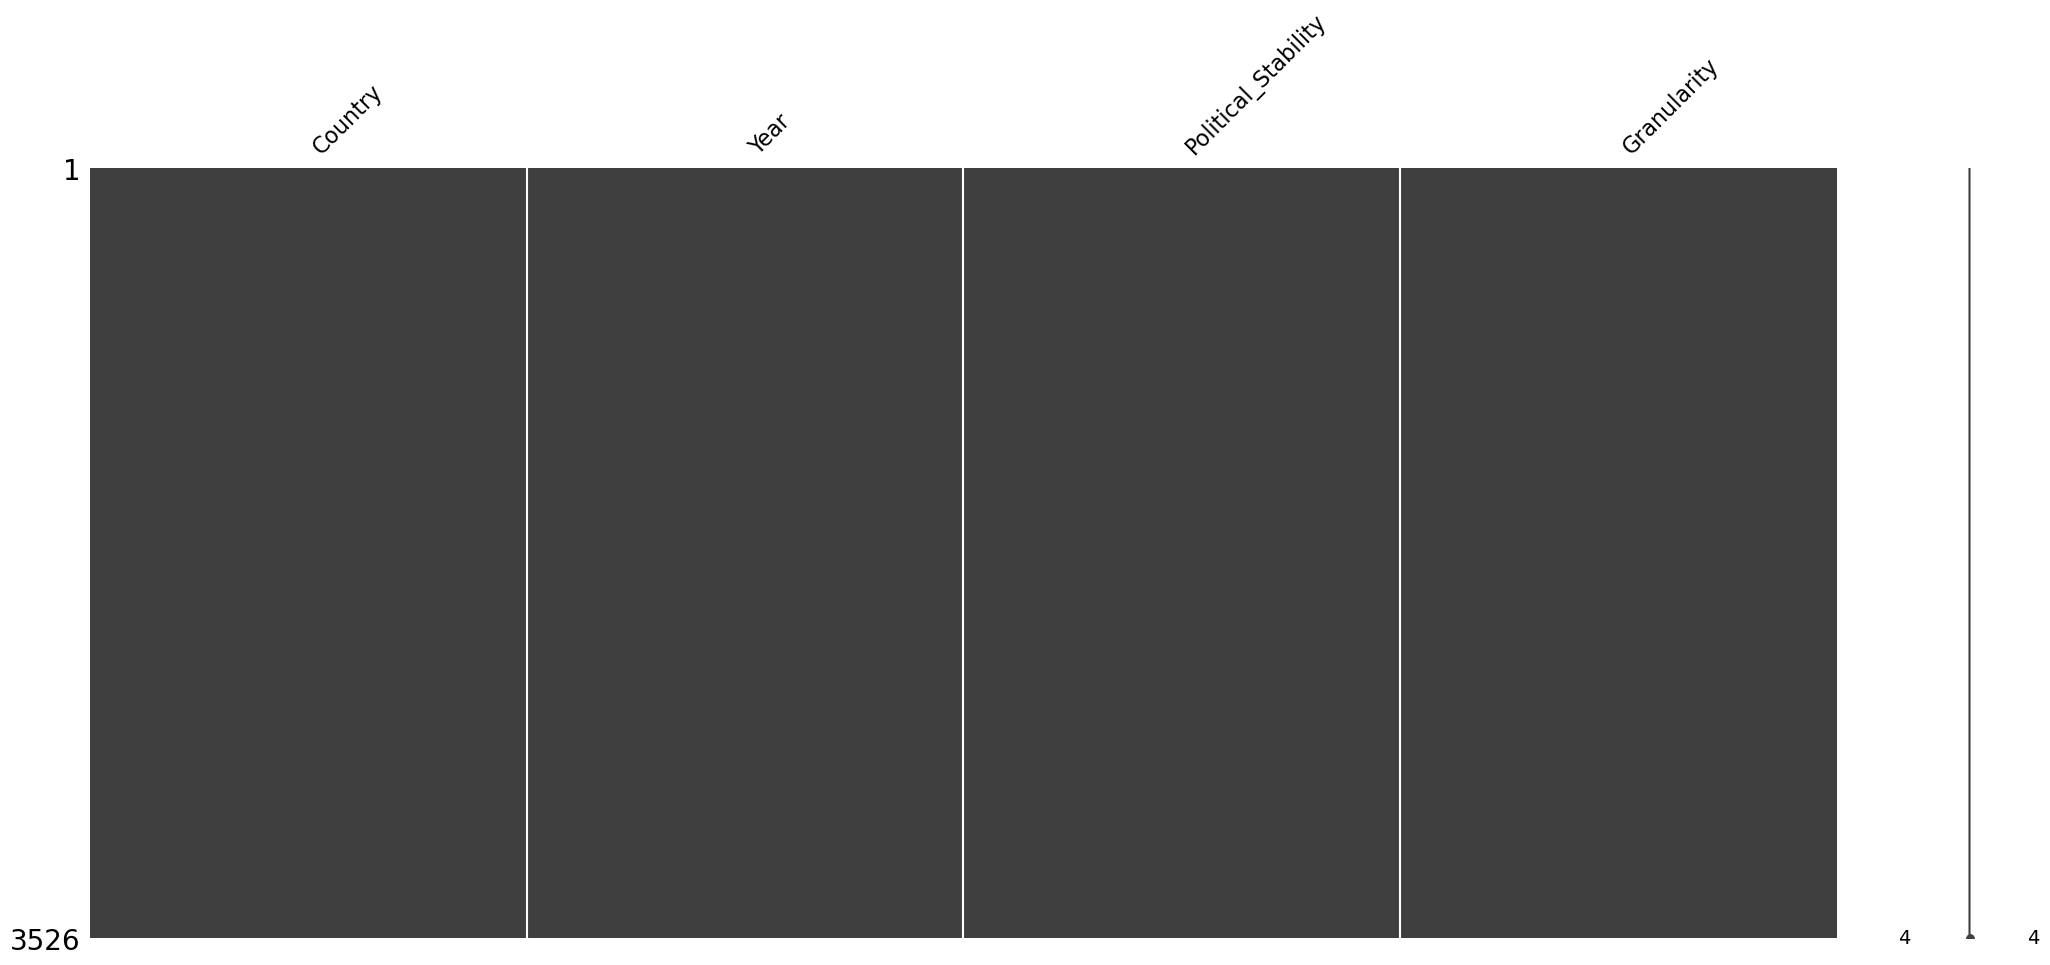

In [17]:
msno.matrix(political_stability)

In [18]:
# count number of null values in countries dataframe
nulls_ps = political_stability.isna().sum().sum()
if nulls_ps == 0:
    print("There are no null values in the table.")
else:
    print ("There are ", nulls_ps, "null values in the table.")

There are no null values in the table.


In [19]:
# rename columns
political_stability.rename(columns={'Country': 'ps_country_name', 'Year':'ps_year', 'Political_Stability':'political_stability'}, inplace=True)

In [20]:
# type casting
political_stability['ps_country_name'] = political_stability['ps_country_name'].astype('string')
political_stability['ps_year'] = political_stability['ps_year'].astype('int')
political_stability['political_stability'] = political_stability['political_stability'].astype('float')

In [21]:
print ("Il y a",political_stability['ps_country_name'].nunique(), "pays dans la liste.")
if (political_stability.loc[political_stability.duplicated() == True].shape[0]) != 0:
    print("Doublons dans la table.")
else:
    print ("Aucun doublon dans la table.")

Il y a 200 pays dans la liste.
Aucun doublon dans la table.


In [22]:
print("Pays ayant un indice de stabilite politique mais absents du referentiel pays:")
countries_out = isInList(political_stability['ps_country_name'].unique().tolist(), countries['country_name'].unique().tolist())
print(countries_out)

Pays ayant un indice de stabilite politique mais absents du referentiel pays:
['American Samoa', 'Bermuda', 'China, Hong Kong SAR', 'China, Macao SAR', 'China, mainland', 'China, Taiwan Province of', 'Greenland', 'North Macedonia', 'Palestine', 'Puerto Rico']


In [23]:
print("Pays du referentiel n'ayant pas d'indice de stabilite politique:")
isInList(countries['country_name'].unique().tolist(), political_stability['ps_country_name'].unique().tolist())

Pays du referentiel n'ayant pas d'indice de stabilite politique:


['China', 'Monaco', 'Republic of North Macedonia', 'San Marino']

In [24]:
# replace China, mainland with its correct name in countries list
political_stability.loc[(political_stability['ps_country_name'] == 'China, mainland'), 'ps_country_name'] = 'China'

In [25]:
print("Pays du referentiel n'ayant pas d'indice de stabilite politique:")
isInList(countries['country_name'].unique().tolist(), political_stability['ps_country_name'].unique().tolist())
print(countries_out)

Pays du referentiel n'ayant pas d'indice de stabilite politique:
['American Samoa', 'Bermuda', 'China, Hong Kong SAR', 'China, Macao SAR', 'China, mainland', 'China, Taiwan Province of', 'Greenland', 'North Macedonia', 'Palestine', 'Puerto Rico']


In [26]:
# remove countries for which political stability index is missing
political_stability_trim = political_stability.loc[(political_stability['ps_country_name'].isin(countries_out) == False)].copy()

In [28]:
# reorder columns to set primary key as first column
political_stability_final = political_stability_trim[['ps_country_name', 'ps_year','political_stability']].copy()

In [29]:
# export df to csv file
political_stability_final.to_csv('C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/DWFA_political_stability_final.csv', index=False, encoding='latin_1')

### 3 - table population

In [32]:
# import file - source : 
pop = pd.read_csv('population.csv', encoding='latin_1')
pop.describe()

,Year,Population
count,20914.000,20914.000
mean,2009.047,22531.641
std,5.479,100016.851
min,2000.000,0.000
25%,2004.000,348.346
50%,2009.000,3016.337
75%,2014.000,11150.426
max,2018.000,1459377.612


<AxesSubplot:>

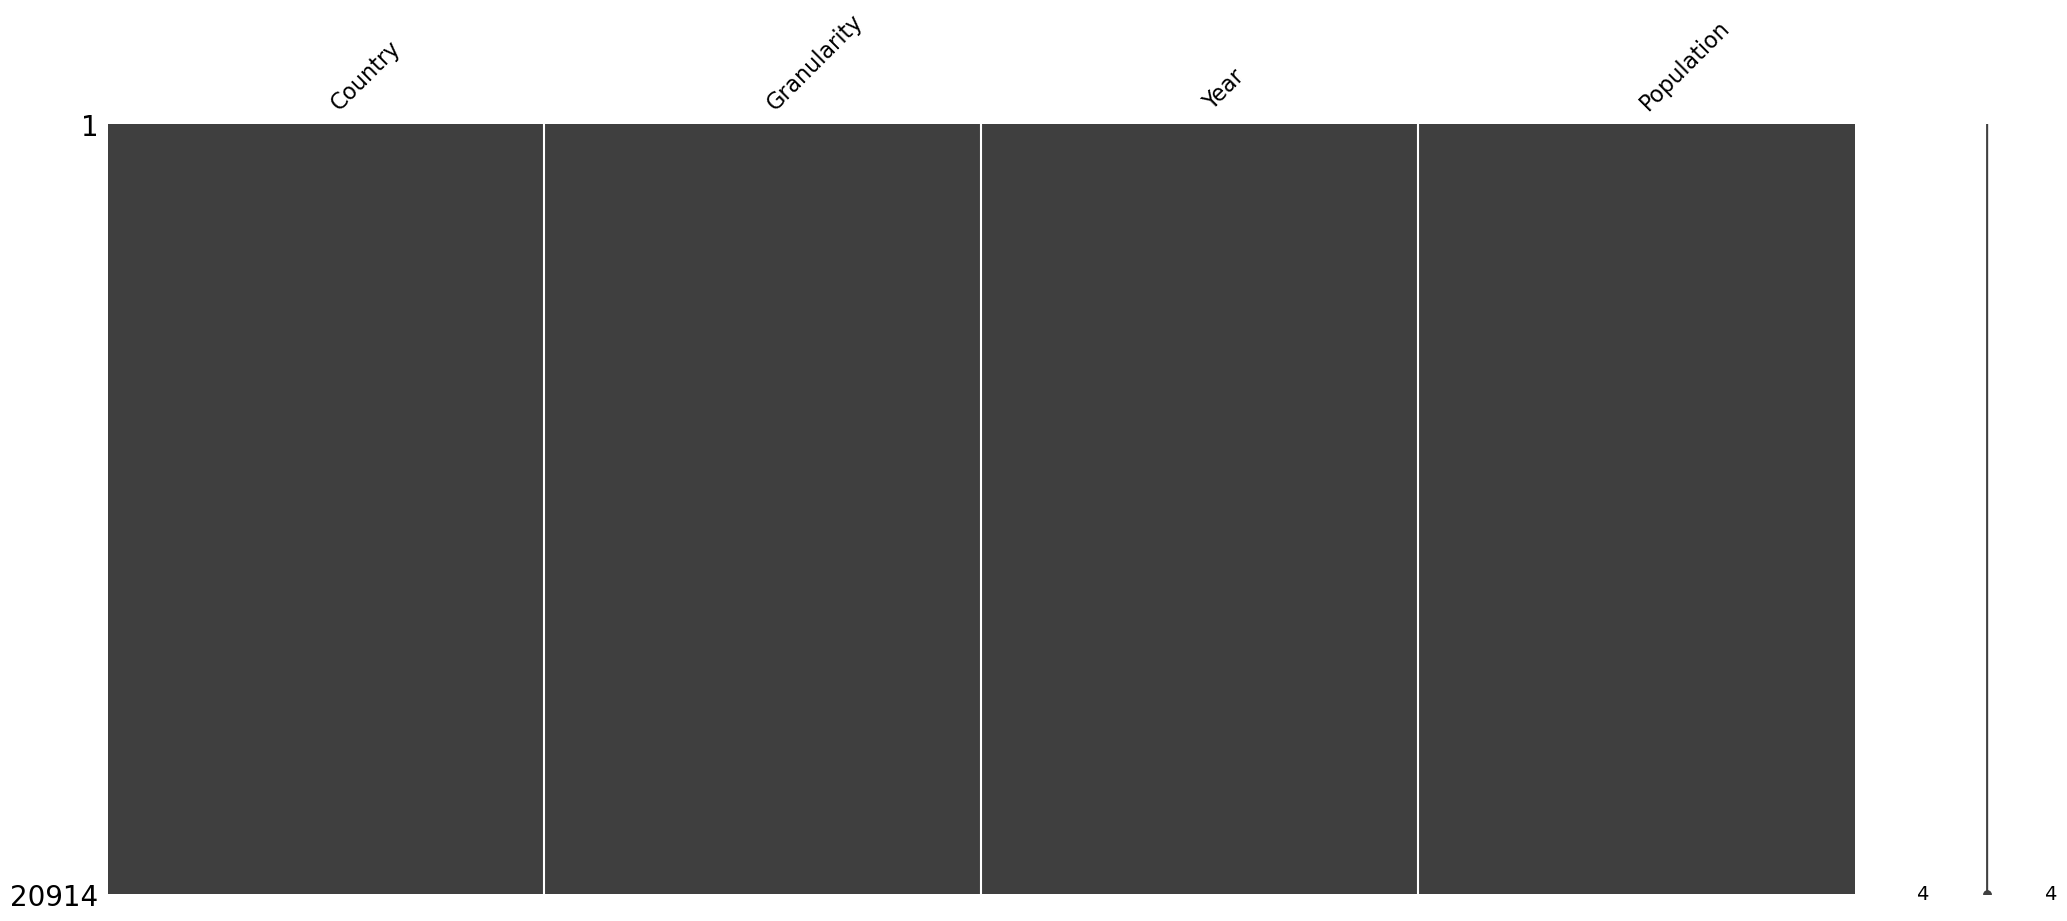

In [33]:
msno.matrix(pop)

In [34]:
# count number of null values in countries dataframe
nulls_pop = pop.isna().sum().sum()
if nulls_pop == 0:
    print("There are no null values in the table.")
else:
    print ("There are ", nulls_pop, "null values in the table.")

There are no null values in the table.


In [35]:
# un-pivot data
pop_trim = pop.pivot(index=['Country','Year'], columns='Granularity', values='Population').reset_index()
pop_trim.head()

Granularity,Country,Year,Female,Male,Rural,Total,Urban
0,Afghanistan,2000,10090.449,10689.508,15657.474,20779.953,4436.282
1,Afghanistan,2001,10489.238,11117.754,16318.324,21606.988,4648.139
2,Afghanistan,2002,10958.668,11642.106,17086.910,22600.770,4893.013
3,Afghanistan,2003,11466.237,12214.634,17909.063,23680.871,5155.788
4,Afghanistan,2004,11962.963,12763.726,18692.107,24726.684,5426.872


In [36]:
# change units
pop_trim['female_population'] = pop_trim['Female'] * 1000
pop_trim['male_population'] = pop_trim['Male'] * 1000
pop_trim['rural_population'] = pop_trim['Rural'] * 1000
pop_trim['urban_population'] = pop_trim['Urban'] * 1000
pop_trim.rename(columns={'Country': 'p_country_name', 'Year':'p_year'}, inplace=True)

In [37]:
# reorder columns
population = pop_trim[['p_country_name', 'p_year', 'female_population','male_population','rural_population','urban_population']].copy()

In [38]:
print("Pays ayant des donnees de population mais absents du referentiel pays:")
countries_out_2 = isInList(population['p_country_name'].unique().tolist(), countries['country_name'].unique().tolist())
print(countries_out_2)

Pays ayant des donnees de population mais absents du referentiel pays:
['American Samoa', 'Anguilla', 'Aruba', 'Bermuda', 'Bonaire, Sint Eustatius and Saba', 'British Virgin Islands', 'Cayman Islands', 'Channel Islands', 'China, Hong Kong SAR', 'China, Macao SAR', 'China, Taiwan Province of', 'China, mainland', 'Curaçao', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'French Guyana', 'French Polynesia', 'Gibraltar', 'Greenland', 'Guadeloupe', 'Guam', 'Holy See', 'Isle of Man', 'Liechtenstein', 'Martinique', 'Mayotte', 'Montserrat', 'Netherlands Antilles (former)', 'New Caledonia', 'North Macedonia', 'Northern Mariana Islands', 'Palestine', 'Puerto Rico', 'Réunion', 'Saint Barthélemy', 'Saint Helena, Ascension and Tristan da Cunha', 'Saint Pierre and Miquelon', 'Saint-Martin (French part)', 'Serbia and Montenegro', 'Sint Maarten  (Dutch part)', 'Sudan (former)', 'Tokelau', 'Turks and Caicos Islands', 'United States Virgin Islands', 'Wallis and Futuna Islands', 'Western Sahara']


In [39]:
print("Pays du referentiel n'ayant pas de donnees de population:")
isInList(countries['country_name'].unique().tolist(), population['p_country_name'].unique().tolist())


Pays du referentiel n'ayant pas de donnees de population:


['Republic of North Macedonia']

In [40]:
nulls_pop = population[population.isnull().any(axis=1)]
countries_out_3 = nulls_pop['p_country_name'].unique()
print(countries_out_3)

['American Samoa' 'Andorra' 'Anguilla' 'Bermuda'
 'Bonaire, Sint Eustatius and Saba' 'British Virgin Islands'
 'Cayman Islands' 'Cook Islands' 'Dominica' 'Falkland Islands (Malvinas)'
 'Faroe Islands' 'Gibraltar' 'Greenland' 'Holy See' 'Isle of Man'
 'Liechtenstein' 'Marshall Islands' 'Monaco' 'Montserrat' 'Nauru' 'Niue'
 'Northern Mariana Islands' 'Palau' 'Saint Barthélemy'
 'Saint Helena, Ascension and Tristan da Cunha' 'Saint Kitts and Nevis'
 'Saint Pierre and Miquelon' 'Saint-Martin (French part)' 'San Marino'
 'Sint Maarten  (Dutch part)' 'Tokelau' 'Turks and Caicos Islands'
 'Tuvalu' 'Wallis and Futuna Islands']


In [41]:
# remove countries which have missing data or are overseas territories of another country
population_final = population.loc[(population['p_country_name'].isin(countries_out_2) == False)
                                 & (population['p_country_name'].isin(countries_out_3) == False)].copy()

In [43]:
isInList(population_final['p_country_name'].unique().tolist(), countries['country_name'].unique().tolist())

[]

In [44]:
isInList(countries['country_name'].unique().tolist(), population_final['p_country_name'].unique().tolist())

['Andorra',
 'Monaco',
 'Niue',
 'Republic of North Macedonia',
 'San Marino',
 'Tuvalu',
 'Cook Islands',
 'Dominica',
 'Marshall Islands',
 'Nauru',
 'Palau',
 'Saint Kitts and Nevis']

In [45]:
# type casting
population_final['p_country_name'] = population_final['p_country_name'].astype('string')
population_final['p_year'] = population_final['p_year'].astype('int')
population_final['female_population'] = population_final['female_population'].astype('int')
population_final['male_population'] = population_final['male_population'].astype('int')
population_final['rural_population'] = population_final['rural_population'].astype('int')
population_final['urban_population'] = population_final['urban_population'].astype('int')

In [46]:
# export df to csv file
population_final.to_csv('C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/DWFA_population_final.csv', index=False, encoding='latin_1')

### 4 - table water_access

In [49]:
# import file - source : 
water_access = pd.read_csv('drinking_water.csv', encoding='latin_1')
water_access.describe()

,Year,Population using at least basic drinking-water services (%),Population using safely managed drinking-water services (%)
count,10476.000,9415.000,3286.000
mean,2008.500,83.962,66.071
std,5.188,19.968,30.384
min,2000.000,4.083,0.000
25%,2004.000,75.928,41.896
50%,2008.500,93.115,73.967
75%,2013.000,98.954,94.777
max,2017.000,100.000,100.000


<AxesSubplot:>

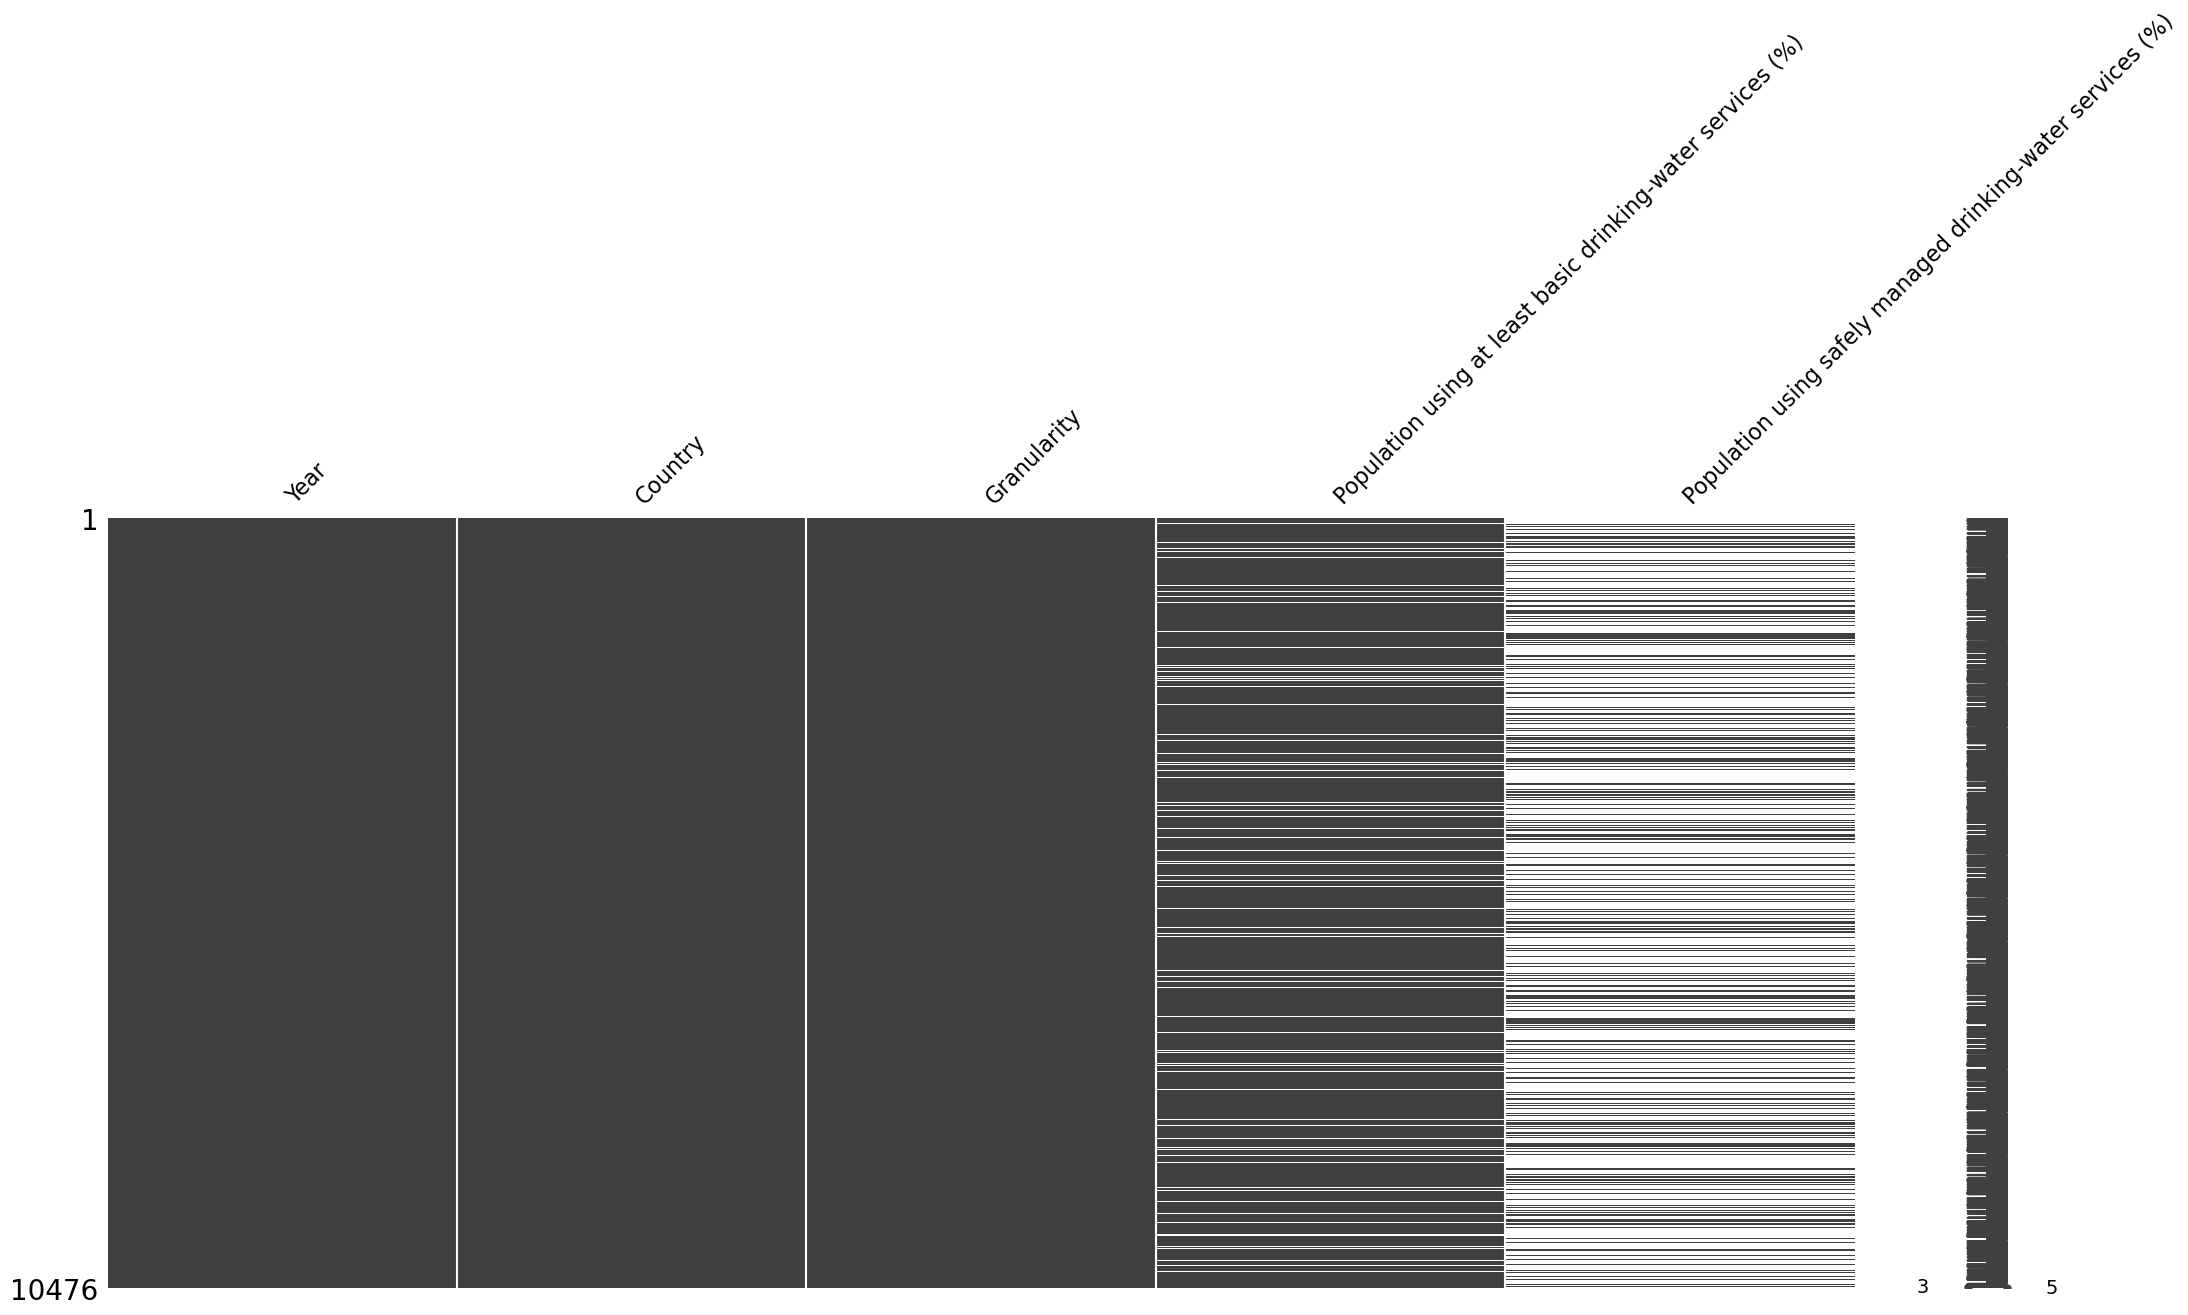

In [50]:
msno.matrix(water_access)

In [51]:
# count number of null values in countries dataframe
nulls_wa = water_access.isna().sum().sum()
if nulls_wa == 0:
    print("There are no null values in the table.")
else:
    print ("There are ", nulls_wa, "null values in the table.")

There are  8251 null values in the table.


In [53]:
# un-pivot data
wa_trim_1 = water_access.pivot(index=['Country','Year'], columns='Granularity', values='Population using at least basic drinking-water services (%)').reset_index()
wa_trim_1.head()

Granularity,Country,Year,Rural,Total,Urban
0,Afghanistan,2000,21.619,27.772,49.487
1,Afghanistan,2001,21.619,27.797,49.487
2,Afghanistan,2002,23.600,29.901,51.904
3,Afghanistan,2003,25.581,32.005,54.321
4,Afghanistan,2004,27.561,34.126,56.739


In [54]:
# filter data
wa_trim_2 = water_access.loc[water_access['Granularity'] == 'Total'][['Year', 'Country', 'Population using safely managed drinking-water services (%)']]
wa_trim_2.head()

,Year,Country,Population using safely managed drinking-water services (%)
1,2000,Afghanistan,NaN
4,2000,Albania,49.293
7,2000,Algeria,NaN
10,2000,Andorra,90.640
13,2000,Angola,NaN


In [55]:
# count number of null values in countries dataframe
nulls_wa_trim_2 = wa_trim_2.isna().sum().sum()
if nulls_wa_trim_2 == 0:
    print("There are no null values in the table.")
else:
    print ("There are ", nulls_wa_trim_2, "null values in the table.")

There are  1747 null values in the table.


In [56]:
# merge data
wa_trim_final = pd.merge(wa_trim_1, wa_trim_2, on=['Year','Country'])
wa_trim_final.head()

,Country,Year,Rural,Total,Urban,Population using safely managed drinking-water services (%)
0,Afghanistan,2000,21.619,27.772,49.487,NaN
1,Afghanistan,2001,21.619,27.797,49.487,NaN
2,Afghanistan,2002,23.600,29.901,51.904,NaN
3,Afghanistan,2003,25.581,32.005,54.321,NaN
4,Afghanistan,2004,27.561,34.126,56.739,NaN


In [57]:
# rename columns
wa_trim_final.rename(columns={'Country': 'p_country_name', 'Year':'p_year', 'Rural': 'water_rural_basic_%', 'Total':'total_basic_%', 'Urban': 'water_urban_basic_%',
                             "Population using safely managed drinking-water services (%)":'water_total_safe_%'}, inplace=True)
wa_trim_final.head()

,p_country_name,p_year,water_rural_basic_%,total_basic_%,water_urban_basic_%,water_total_safe_%
0,Afghanistan,2000,21.619,27.772,49.487,NaN
1,Afghanistan,2001,21.619,27.797,49.487,NaN
2,Afghanistan,2002,23.600,29.901,51.904,NaN
3,Afghanistan,2003,25.581,32.005,54.321,NaN
4,Afghanistan,2004,27.561,34.126,56.739,NaN


In [58]:
# merge data
wa_trim_final_2 = pd.merge(wa_trim_final, population_final, on=['p_country_name','p_year'])
wa_trim_final_2.head()

,p_country_name,p_year,water_rural_basic_%,total_basic_%,water_urban_basic_%,water_total_safe_%,female_population,male_population,rural_population,urban_population
0,Afghanistan,2000,21.619,27.772,49.487,NaN,10090449,10689508,15657474,4436282
1,Afghanistan,2001,21.619,27.797,49.487,NaN,10489238,11117754,16318324,4648139
2,Afghanistan,2002,23.600,29.901,51.904,NaN,10958668,11642106,17086910,4893013
3,Afghanistan,2003,25.581,32.005,54.321,NaN,11466237,12214634,17909063,5155788
4,Afghanistan,2004,27.561,34.126,56.739,NaN,11962963,12763726,18692107,5426872


In [59]:
# add total population
wa_trim_final_2['pop_tot'] = wa_trim_final_2['female_population'] + wa_trim_final_2['male_population']
wa_trim_final_2.head()

,p_country_name,p_year,water_rural_basic_%,total_basic_%,water_urban_basic_%,water_total_safe_%,female_population,male_population,rural_population,urban_population,pop_tot
0,Afghanistan,2000,21.619,27.772,49.487,NaN,10090449,10689508,15657474,4436282,20779957
1,Afghanistan,2001,21.619,27.797,49.487,NaN,10489238,11117754,16318324,4648139,21606992
2,Afghanistan,2002,23.600,29.901,51.904,NaN,10958668,11642106,17086910,4893013,22600774
3,Afghanistan,2003,25.581,32.005,54.321,NaN,11466237,12214634,17909063,5155788,23680871
4,Afghanistan,2004,27.561,34.126,56.739,NaN,11962963,12763726,18692107,5426872,24726689


In [60]:
# add calculations
wa_trim_final_2['water_rural_basic_mio'] = round((wa_trim_final_2['water_rural_basic_%'] / 100) * wa_trim_final_2['rural_population'], 0)
wa_trim_final_2['water_urban_basic_mio'] = round((wa_trim_final_2['water_urban_basic_%'] / 100) * wa_trim_final_2['urban_population'], 0)
wa_trim_final_2['total_basic_mio'] = round((wa_trim_final_2['total_basic_%'] / 100) * wa_trim_final_2['pop_tot'], 0)
wa_trim_final_2['water_total_safe_mio'] = round((wa_trim_final_2['water_total_safe_%'] / 100) * wa_trim_final_2['pop_tot'], 0)
wa_trim_final_2.head()

,p_country_name,p_year,water_rural_basic_%,total_basic_%,water_urban_basic_%,water_total_safe_%,female_population,male_population,rural_population,urban_population,pop_tot,water_rural_basic_mio,water_urban_basic_mio,total_basic_mio,water_total_safe_mio
0,Afghanistan,2000,21.619,27.772,49.487,NaN,10090449,10689508,15657474,4436282,20779957,3385010.000,2195403.000,5770989.000,NaN
1,Afghanistan,2001,21.619,27.797,49.487,NaN,10489238,11117754,16318324,4648139,21606992,3527880.000,2300245.000,6006152.000,NaN
2,Afghanistan,2002,23.600,29.901,51.904,NaN,10958668,11642106,17086910,4893013,22600774,4032490.000,2539692.000,6757803.000,NaN
3,Afghanistan,2003,25.581,32.005,54.321,NaN,11466237,12214634,17909063,5155788,23680871,4581251.000,2800701.000,7579079.000,NaN
4,Afghanistan,2004,27.561,34.126,56.739,NaN,11962963,12763726,18692107,5426872,24726689,5151803.000,3079126.000,8438287.000,NaN


In [61]:
# reorder columns
drinking_water_final = wa_trim_final_2[['p_country_name','p_year','pop_tot', 'water_rural_basic_mio','water_urban_basic_mio','total_basic_mio','water_total_safe_mio']].copy() 
drinking_water_final.head()

,p_country_name,p_year,pop_tot,water_rural_basic_mio,water_urban_basic_mio,total_basic_mio,water_total_safe_mio
0,Afghanistan,2000,20779957,3385010.000,2195403.000,5770989.000,NaN
1,Afghanistan,2001,21606992,3527880.000,2300245.000,6006152.000,NaN
2,Afghanistan,2002,22600774,4032490.000,2539692.000,6757803.000,NaN
3,Afghanistan,2003,23680871,4581251.000,2800701.000,7579079.000,NaN
4,Afghanistan,2004,24726689,5151803.000,3079126.000,8438287.000,NaN


In [62]:
# type casting - attn cannot type cast if column contains NaNs
drinking_water_final['p_country_name'] = drinking_water_final['p_country_name'].astype('string')

In [63]:
# rename columns
drinking_water_final.rename(columns={'p_country_name': 'dw_country_name', 'p_year':'dw_year'}, inplace=True)
drinking_water_final.head()

,dw_country_name,dw_year,pop_tot,water_rural_basic_mio,water_urban_basic_mio,total_basic_mio,water_total_safe_mio
0,Afghanistan,2000,20779957,3385010.000,2195403.000,5770989.000,NaN
1,Afghanistan,2001,21606992,3527880.000,2300245.000,6006152.000,NaN
2,Afghanistan,2002,22600774,4032490.000,2539692.000,6757803.000,NaN
3,Afghanistan,2003,23680871,4581251.000,2800701.000,7579079.000,NaN
4,Afghanistan,2004,24726689,5151803.000,3079126.000,8438287.000,NaN


In [64]:
# export df to csv file
drinking_water_final.to_csv('C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/DWFA_drinking_water_final.csv', index=False, encoding='latin_1')

### 5 - table wash_mortality

In [65]:
# import file - source : 
wash_mortality = pd.read_csv('wash_mortality.csv', encoding='latin_1')
wash_mortality.describe()

,Year,Mortality rate attributed to exposure to unsafe WASH services,WASH deaths
count,549.000,549.000,183.000
mean,2016.000,12.494,4756.098
std,0.000,20.831,21280.125
min,2016.000,0.004,0.082
25%,2016.000,0.193,11.163
50%,2016.000,1.289,130.983
75%,2016.000,18.055,1950.434
max,2016.000,107.048,246087.900


<AxesSubplot:>

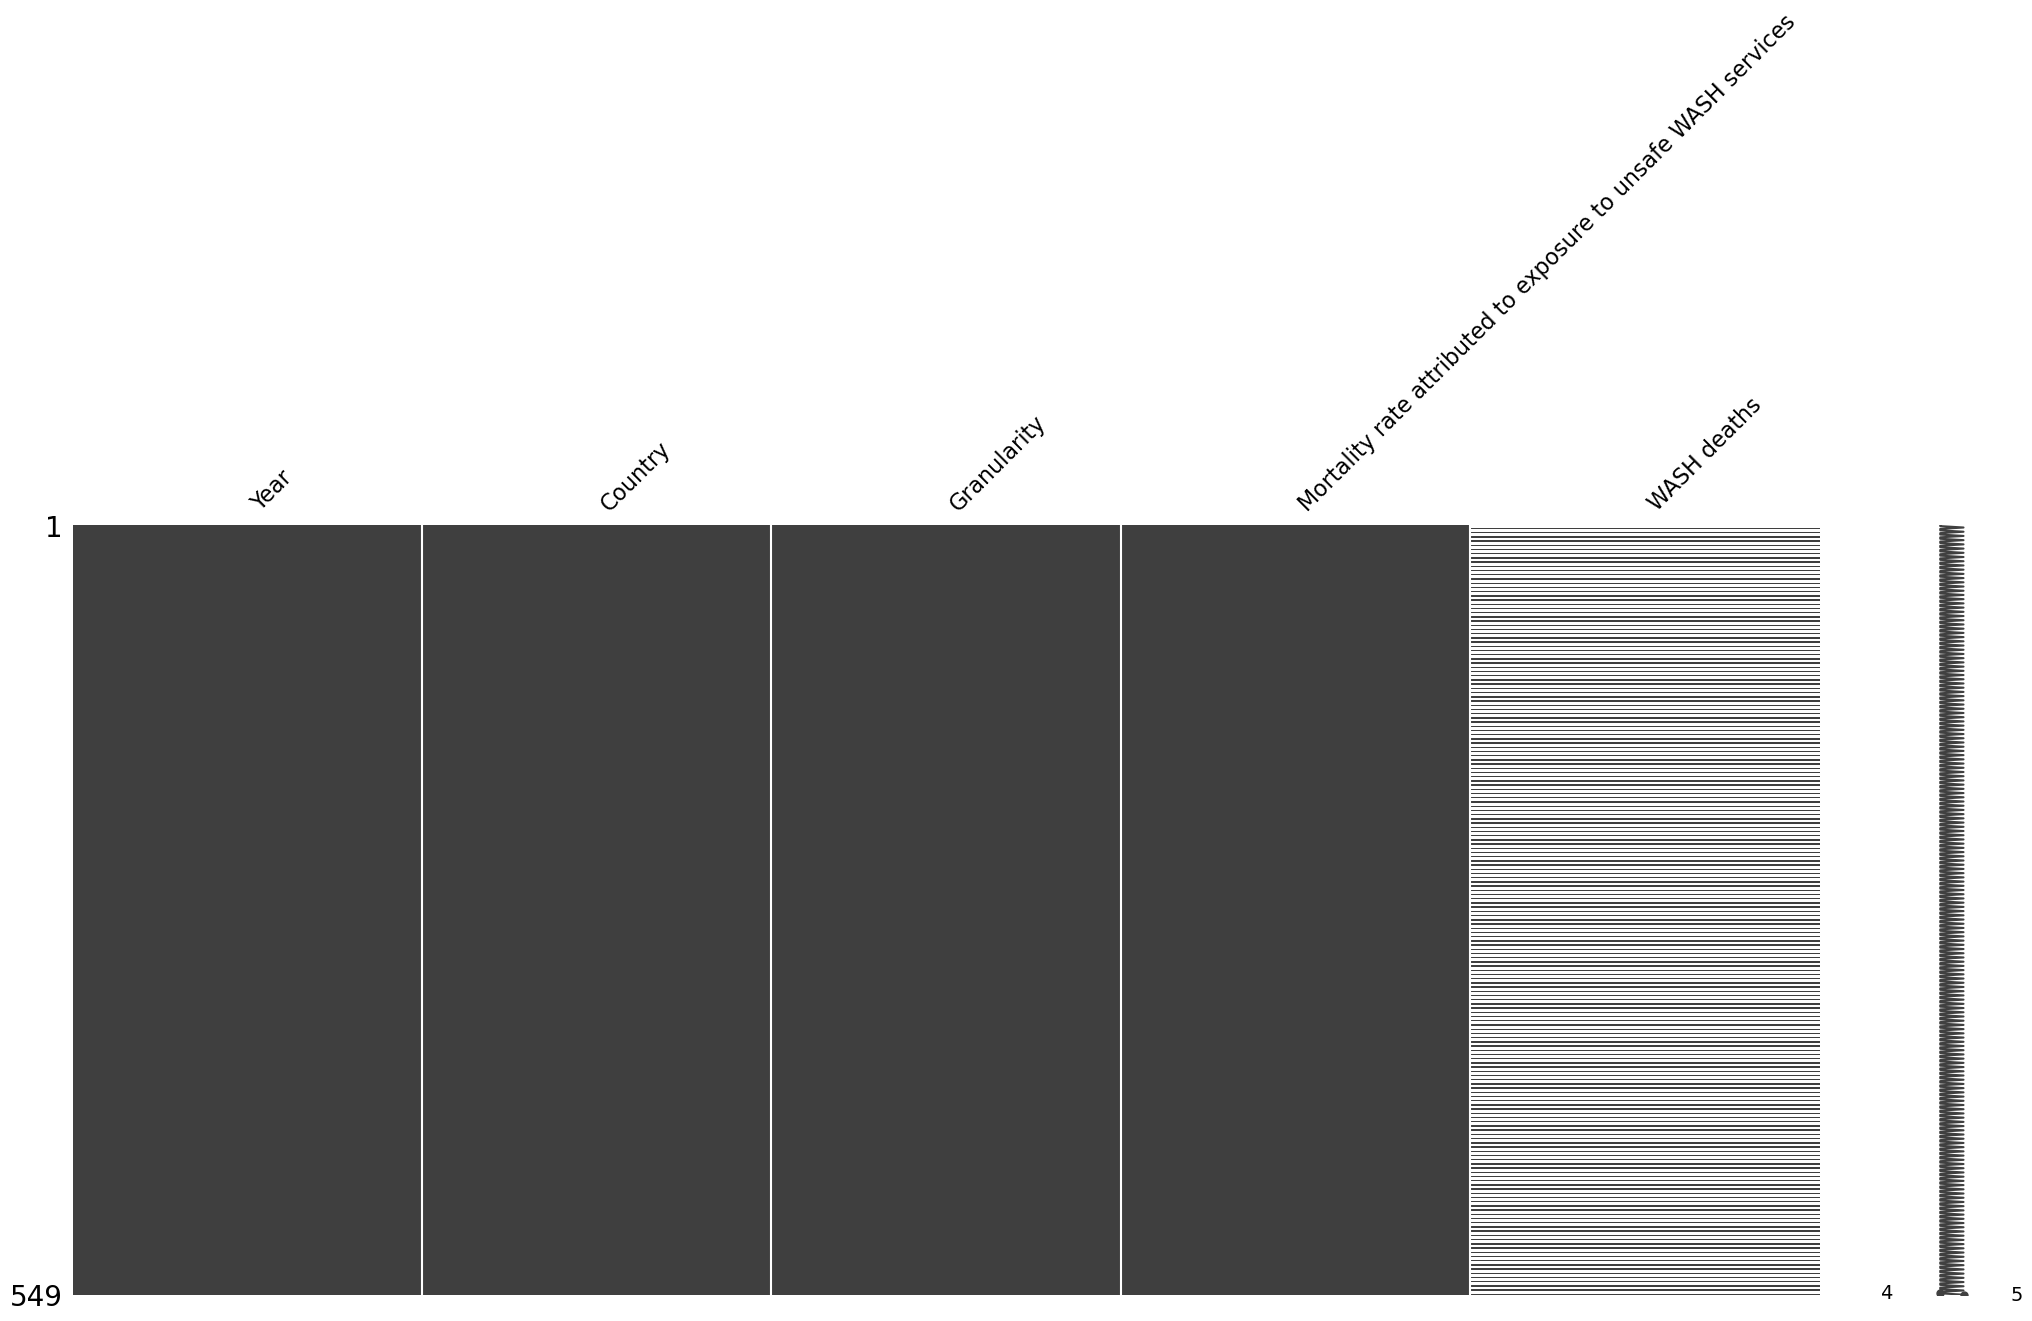

In [66]:
msno.matrix(wash_mortality)

In [67]:
# count number of null values in countries dataframe
nulls_wm = wash_mortality.isna().sum().sum()
if nulls_wm == 0:
    print("There are no null values in the table.")
else:
    print ("There are ", nulls_wm, "null values in the table.")

There are  366 null values in the table.


In [69]:
# un-pivot data
wm_trim_1 = wash_mortality.pivot(index=['Country','Year'], columns='Granularity', values='Mortality rate attributed to exposure to unsafe WASH services').reset_index()
wm_trim_1.head()

Granularity,Country,Year,Female,Male,Total
0,Afghanistan,2016,15.312,12.613,13.921
1,Albania,2016,0.126,0.206,0.166
2,Algeria,2016,2.199,1.728,1.867
3,Angola,2016,45.150,52.625,48.815
4,Antigua and Barbuda,2016,0.104,0.125,0.114


In [70]:
# filter data
wm_trim_2 = wash_mortality.loc[wash_mortality['Granularity'] == 'Total'][['Year', 'Country', 'WASH deaths']]
wm_trim_2.head()

,Year,Country,WASH deaths
2,2016,Afghanistan,4824.353
5,2016,Albania,4.870
8,2016,Algeria,758.210
11,2016,Angola,14065.200
14,2016,Antigua and Barbuda,0.115


In [71]:
# merge data
wm_trim_final = pd.merge(wm_trim_1, wm_trim_2, on=['Country','Year'])
wm_trim_final.rename(columns={'Female': 'Female_per100k', 'Male':'Male_per100k', 'Total':'Total_per100k'}, inplace=True)
wm_trim_final.head()

,Country,Year,Female_per100k,Male_per100k,Total_per100k,WASH deaths
0,Afghanistan,2016,15.312,12.613,13.921,4824.353
1,Albania,2016,0.126,0.206,0.166,4.870
2,Algeria,2016,2.199,1.728,1.867,758.210
3,Angola,2016,45.150,52.625,48.815,14065.200
4,Antigua and Barbuda,2016,0.104,0.125,0.114,0.115


In [72]:
# filter data and rename columns
population_2016 = population_final.loc[population_final['p_year'] == 2016].copy()
population_2016.rename(columns={'p_country_name': 'Country', 'p_year':'Year'}, inplace=True)
population_2016.head()

Granularity,Country,Year,female_population,male_population,rural_population,urban_population
16,Afghanistan,2016,17196034,18186994,25985093,8670939
35,Albania,2016,1415879,1470548,1216737,1709611
54,Algeria,2016,20069497,20481901,11589537,29016515
111,Angola,2016,14576127,14266355,10329860,18483603
149,Antigua and Barbuda,2016,49002,45518,75878,25085


In [73]:
# merge data
wm_trim_final_2 = pd.merge(wm_trim_final, population_2016, on=['Country','Year'])
wm_trim_final_2.head()

,Country,Year,Female_per100k,Male_per100k,Total_per100k,WASH deaths,female_population,male_population,rural_population,urban_population
0,Afghanistan,2016,15.312,12.613,13.921,4824.353,17196034,18186994,25985093,8670939
1,Albania,2016,0.126,0.206,0.166,4.870,1415879,1470548,1216737,1709611
2,Algeria,2016,2.199,1.728,1.867,758.210,20069497,20481901,11589537,29016515
3,Angola,2016,45.150,52.625,48.815,14065.200,14576127,14266355,10329860,18483603
4,Antigua and Barbuda,2016,0.104,0.125,0.114,0.115,49002,45518,75878,25085


In [74]:
# add calculations
wm_trim_final_2['female_wash_deaths'] = wm_trim_final_2['Female_per100k'] * wm_trim_final_2['female_population'] / 100000
wm_trim_final_2['male_wash_deaths'] = wm_trim_final_2['Male_per100k'] * wm_trim_final_2['male_population'] / 100000
wm_trim_final_2['total_deaths'] = wm_trim_final_2['female_wash_deaths'] + wm_trim_final_2['male_wash_deaths']
wm_trim_final_2.head()

,Country,Year,Female_per100k,Male_per100k,Total_per100k,WASH deaths,female_population,male_population,rural_population,urban_population,female_wash_deaths,male_wash_deaths,total_deaths
0,Afghanistan,2016,15.312,12.613,13.921,4824.353,17196034,18186994,25985093,8670939,2633.045,2293.920,4926.965
1,Albania,2016,0.126,0.206,0.166,4.870,1415879,1470548,1216737,1709611,1.777,3.037,4.814
2,Algeria,2016,2.199,1.728,1.867,758.210,20069497,20481901,11589537,29016515,441.308,354.003,795.311
3,Angola,2016,45.150,52.625,48.815,14065.200,14576127,14266355,10329860,18483603,6581.156,7507.678,14088.834
4,Antigua and Barbuda,2016,0.104,0.125,0.114,0.115,49002,45518,75878,25085,0.051,0.057,0.108


In [75]:
# filter data and rename columns
wash_deaths_2016_final = wm_trim_final_2[['Country', 'WASH deaths', 'female_wash_deaths','male_wash_deaths']].copy()
wash_deaths_2016_final.rename(columns={'Country': 'wm_country_name', 'WASH deaths':'total_deaths', 'female_wash_deaths':'female_deaths','male_wash_deaths':'male_deaths'}, inplace=True)
wash_deaths_2016_final.head()

,wm_country_name,total_deaths,female_deaths,male_deaths
0,Afghanistan,4824.353,2633.045,2293.920
1,Albania,4.870,1.777,3.037
2,Algeria,758.210,441.308,354.003
3,Angola,14065.200,6581.156,7507.678
4,Antigua and Barbuda,0.115,0.051,0.057


In [76]:
# export df to csv file
wash_deaths_2016_final.to_csv('C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/DWFA_wash_deaths_2016_final.csv', index=False, encoding='latin_1')

### 6 - merge data tables & load into database

#### 6.1 - Table fao_data

In [79]:
# rename columns
political_stability_final.rename(columns={'ps_country_name': 'p_country_name', 'ps_year':'p_year'}, inplace=True)
political_stability_final.head()

,p_country_name,p_year,political_stability
0,Afghanistan,2000,-2.440
1,Afghanistan,2002,-2.040
2,Afghanistan,2003,-2.200
3,Afghanistan,2004,-2.300
4,Afghanistan,2005,-2.070


In [80]:
# merge data and rename columns
fao_data = pd.merge(wa_trim_final_2, political_stability_final, how='left', left_on=['p_country_name','p_year'], right_on=['p_country_name','p_year'])[['p_country_name','p_year','female_population', 'male_population', 'rural_population', 'urban_population','political_stability','water_rural_basic_mio', 'water_urban_basic_mio', 'water_total_safe_mio']]


fao_data.rename(columns={'p_country_name': 'fao_country_name', 'p_year':'fao_year', 'water_rural_basic_mio':'water_rural_basic', 'water_urban_basic_mio':'water_urban_basic', 'water_total_safe_mio':'water_total_safe'}, inplace=True)

# replace missing values with zeros
fao_data.fillna(0, inplace = True)
fao_data.head()

,fao_country_name,fao_year,female_population,male_population,rural_population,urban_population,political_stability,water_rural_basic,water_urban_basic,water_total_safe
0,Afghanistan,2000,10090449,10689508,15657474,4436282,-2.440,3385010.000,2195403.000,0.000
1,Afghanistan,2001,10489238,11117754,16318324,4648139,0.000,3527880.000,2300245.000,0.000
2,Afghanistan,2002,10958668,11642106,17086910,4893013,-2.040,4032490.000,2539692.000,0.000
3,Afghanistan,2003,11466237,12214634,17909063,5155788,-2.200,4581251.000,2800701.000,0.000
4,Afghanistan,2004,11962963,12763726,18692107,5426872,-2.300,5151803.000,3079126.000,0.000


In [81]:
# export df to csv file
fao_data.to_csv('C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/DWFA_fao_data.csv', index=False, encoding='latin_1')

In [82]:
# load csv file into db
load_fao_data = "LOAD DATA INFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/DWFA_fao_data.csv' INTO TABLE fao_data CHARACTER SET latin1 FIELDS TERMINATED BY ',' LINES TERMINATED BY '\r\n' IGNORE 1 ROWS"
cursor.execute("SET FOREIGN_KEY_CHECKS=0")
cursor.execute(load_fao_data)
cursor.execute("SET FOREIGN_KEY_CHECKS=1")

#### 6.2 - Table wash_mortality_2016

In [84]:
wash_mortality_2016 = wash_deaths_2016_final[['wm_country_name', 'female_deaths', 'male_deaths']]
wash_mortality_2016.head()

,wm_country_name,female_deaths,male_deaths
0,Afghanistan,2633.045,2293.920
1,Albania,1.777,3.037
2,Algeria,441.308,354.003
3,Angola,6581.156,7507.678
4,Antigua and Barbuda,0.051,0.057


In [85]:
# export df to csv file
wash_mortality_2016.to_csv('C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/DWFA_wash_mortality_2016.csv', index=False, encoding='latin_1')

In [86]:
# load csv file into db
load_wash_mortality_2016 = "LOAD DATA INFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/DWFA_wash_mortality_2016.csv' INTO TABLE wash_mortality_2016 CHARACTER SET latin1 FIELDS TERMINATED BY ',' LINES TERMINATED BY '\r\n' IGNORE 1 ROWS"
cursor.execute("SET FOREIGN_KEY_CHECKS=0")
cursor.execute(load_wash_mortality_2016)
cursor.execute("SET FOREIGN_KEY_CHECKS=1")

In [88]:
# replace missing values with zeros
update_fao_data_1 = "UPDATE fao_data SET water_total_safe=NULL WHERE water_total_safe=0"
update_fao_data_2 = "UPDATE fao_data SET political_stability=NULL WHERE political_stability=0"
update_fao_data_3 = "UPDATE fao_data SET water_rural_basic=NULL WHERE water_rural_basic=0"
update_fao_data_4 = "UPDATE fao_data SET water_urban_basic=NULL WHERE water_urban_basic=0"
cursor.execute(update_fao_data_1)
cursor.execute(update_fao_data_2)
cursor.execute(update_fao_data_3)
cursor.execute(update_fao_data_4)

In [89]:
# close connection
connection.close()